#### Task 1: 
- Team: (20 points)
    - Develop Linear and Non-Linear (polynomial with degree n) regression models for predicting cases and deaths in US. 
        - Start your data from 2020.06.01 (Monday) to 2021.01.03 (Sunday) of infections in US.
            X-Axis - number of days, Y-Axis - number of new cases and deaths. (5 points)
        - Calculate and report Root Mean Square Error (RMSE) for your models (linear and non-linear). https://en.wikipedia.org/wiki/Root-mean-square_deviation. Discuss bias versus variance tradeoff. (5 points)
        - Plot trend line along for the data along with the forecast of 1 week ahead (i.e. make prediction on 2021.01.04 - 2021.01.10). (5 points)
        - Describe the trends as compared to other countries. (5 points)

In [1]:
#pip install --user ipykernel
#pip install sktime

In [3]:
#imports
import seaborn as sns
import pandas as pd
import numpy as np
import datetime
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import make_reduction
from sklearn.metrics import mean_squared_error
from sktime.utils.plotting import plot_series

In [4]:
#read in csv files
cases = pd.read_csv("covid_confirmed_usafacts.csv")
deaths = pd.read_csv("covid_deaths_usafacts.csv")

In [55]:
def get_dates(data): #function from stage 2
    dates = data.loc[:, [i not in ["countyFIPS","County Name", "State", "StateFIPS"] for i in data]] #Extract non dates
    
    dates.columns = pd.to_datetime(dates.columns) #Fix columns to be date times
    
    dates = dates.loc[:, [(i >= datetime.datetime(2020, 5, 25)) and (i <= datetime.datetime(2021, 1, 10)) for i in dates]] #Extract correct time
    return dates #make dates start 1 week earlier for get_weekly() purposes

def get_weekly(dates): #tweaked function from stage 2

    weeks = [range(i, i + 7) for i in range(0, len(dates.columns), 7)]
    dates.iloc[:, weeks[0]]
    
    stats = pd.DataFrame({"week": [],"sum" : []})
    
    for i in range(len(weeks)-1):
        date = dates.iloc[:, weeks[i+1]].iloc[0, :].keys()[0]
        #Subtract numbers from previous week to get new case/death data (current data is cumulative)
        week = (dates.iloc[:, weeks[i+1]].sum(axis = 1)) - (dates.iloc[:, weeks[i]].sum(axis = 1))
        wsum = week.sum()/7/7
        new_row = pd.DataFrame({"week": date,"sum" : (wsum)}, index=[i])
        stats = pd.concat([stats, new_row])
    return stats

In [98]:
#set up data
cases_dates = get_dates(cases)
cases_weeks = get_weekly(cases_dates)
cases_weeks.dropna(inplace=True)
cX = cases_weeks["week"]
deaths_dates = get_dates(deaths)
deaths_weeks = get_weekly(deaths_dates)
deaths_weeks.dropna(inplace=True)
dX = deaths_weeks["week"]
cy = cases_weeks["sum"]
dy = deaths_weeks["sum"]

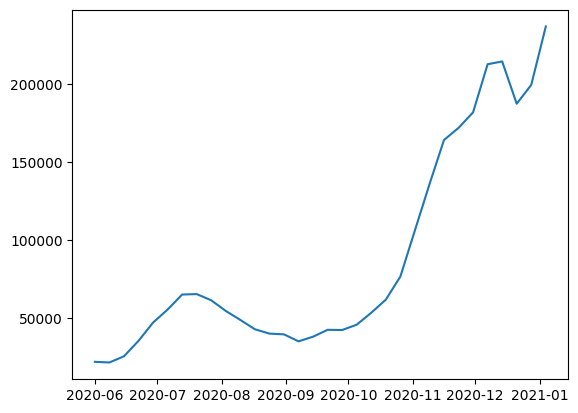

In [65]:
#plot actual case data
plt.plot(cases_weeks["week"], cases_weeks["sum"])

In [83]:
#LinearReg prediction tutorial: 
#https://towardsdatascience.com/build-complex-time-series-regression-pipelines-with-sktime-910bc25c96b6

#tts without randomizing order. test_size=1 for prediction 1 week ahead
cy_train, cy_test = temporal_train_test_split(cy, test_size=1)
fh = ForecastingHorizon(cy_test.index, is_relative=False)
regressor = LinearRegression()
forecaster = make_reduction(regressor, window_length=1, strategy="recursive")

In [84]:
forecaster.fit(cy_train)
cy_pred = forecaster.predict(fh)

(<Figure size 1600x400 with 1 Axes>, <Axes: xlabel='Week', ylabel='New Cases'>)

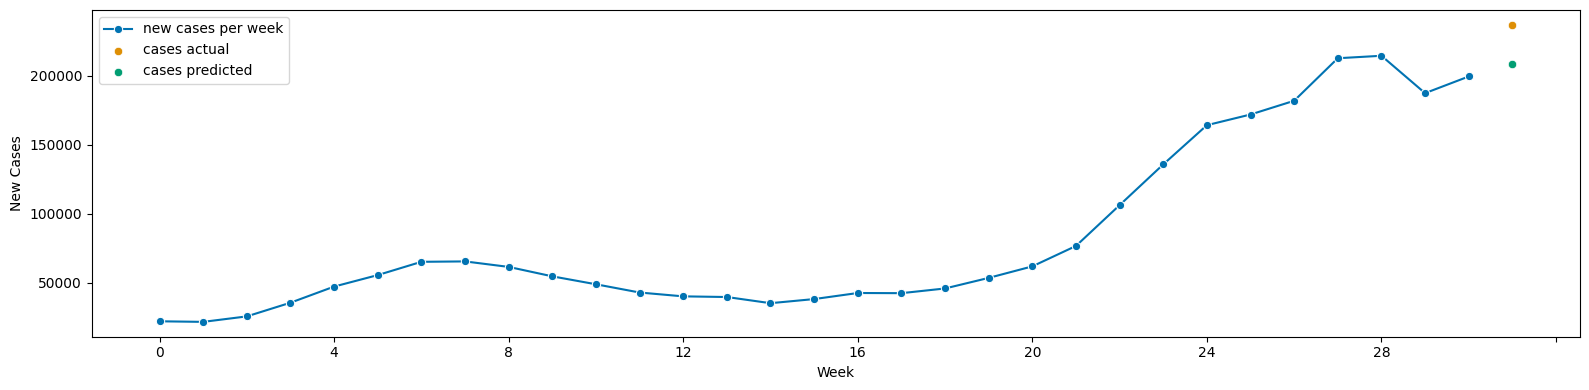

In [99]:

plot_series(cy_train, cy_test, cy_pred, labels=["new cases per week", "cases actual", "cases predicted"], 
            x_label='Week', y_label='New Cases')

In [100]:
MSE = mean_squared_error(cy_test,cy_pred)
print("Linear reg RMSE: ", np.sqrt(MSE))

Linear reg RMSE:  28434.82194498382


In [110]:
# Non-Linear regression tutorial: https://pieriantraining.com/nonlinear-regression-in-machine-learning-python/

cases_weeks['week'] = np.arange(len(cases_weeks['week']))
polynomial_converter = PolynomialFeatures(degree=1,include_bias=False)
poly_features = polynomial_converter.fit_transform(cases_weeks)
#poly_features

In [112]:
#X_train, X_test, y_train, y_test = train_test_split(poly_features, cy, test_size=0.3, random_state=101)
cy_train, cy_test = temporal_train_test_split(poly_features, test_size=1)
fh = ForecastingHorizon(pd.DataFrame(cy_test).index, is_relative=False)
model = LinearRegression(fit_intercept=True)
forecaster = make_reduction(regressor, window_length=1, strategy="recursive")
forecaster.polyfit(cy_train)

train_pred = forecaster.predict(cy_train)
test_pred = pd.Series(model.predict(fh))
train_RMSE = np.sqrt(mean_squared_error(y_train,train_pred))
test_RMSE = np.sqrt(mean_squared_error(y_test,test_pred))

print("train: ", train_RMSE, "\ttest: ", test_RMSE)

#fig, ax = plt.subplots()
ax.plot(cases_weeks, test_pred)
cases_weeks.plot()
test_pred.plot()
ax.set_aspect('equal')


AttributeError: 'RecursiveTabularRegressionForecaster' object has no attribute 'polyfit'